# 4.7.1 The Stock Market data

In [1]:
# imports
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots
import statsmodels.api as sm
from ISLP import load_data
from ISLP.models import (ModelSpec as MS,
                         summarize)

In [3]:
# new imports
from ISLP import confusion_table
from ISLP.models import contrast
from sklearn.discriminant_analysis import \
(LinearDiscriminantAnalysis as LDA ,
QuadraticDiscriminantAnalysis as QDA)
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [4]:
# loading data
Smarket = load_data("Smarket")
Smarket

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction
0,2001,0.381,-0.192,-2.624,-1.055,5.010,1.19130,0.959,Up
1,2001,0.959,0.381,-0.192,-2.624,-1.055,1.29650,1.032,Up
2,2001,1.032,0.959,0.381,-0.192,-2.624,1.41120,-0.623,Down
3,2001,-0.623,1.032,0.959,0.381,-0.192,1.27600,0.614,Up
4,2001,0.614,-0.623,1.032,0.959,0.381,1.20570,0.213,Up
...,...,...,...,...,...,...,...,...,...
1245,2005,0.422,0.252,-0.024,-0.584,-0.285,1.88850,0.043,Up
1246,2005,0.043,0.422,0.252,-0.024,-0.584,1.28581,-0.955,Down
1247,2005,-0.955,0.043,0.422,0.252,-0.024,1.54047,0.130,Up
1248,2005,0.130,-0.955,0.043,0.422,0.252,1.42236,-0.298,Down


In [5]:
Smarket.columns

Index(['Year', 'Lag1', 'Lag2', 'Lag3', 'Lag4', 'Lag5', 'Volume', 'Today',
       'Direction'],
      dtype='object')

In [13]:
corr = Smarket.corr()
corr.style.background_gradient(cmap='coolwarm')

C:\Users\Amruthaa\AppData\Local\Temp\ipykernel_12104\4204197566.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = Smarket.corr()


,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today
Year,1.000000,0.029700,0.030596,0.033195,0.035689,0.029788,0.539006,0.030095
Lag1,0.029700,1.000000,-0.026294,-0.010803,-0.002986,-0.005675,0.040910,-0.026155
Lag2,0.030596,-0.026294,1.000000,-0.025897,-0.010854,-0.003558,-0.043383,-0.010250
Lag3,0.033195,-0.010803,-0.025897,1.000000,-0.024051,-0.018808,-0.041824,-0.002448
Lag4,0.035689,-0.002986,-0.010854,-0.024051,1.000000,-0.027084,-0.048414,-0.006900
Lag5,0.029788,-0.005675,-0.003558,-0.018808,-0.027084,1.000000,-0.022002,-0.034860
Volume,0.539006,0.040910,-0.043383,-0.041824,-0.048414,-0.022002,1.000000,0.014592
Today,0.030095,-0.026155,-0.010250,-0.002448,-0.006900,-0.034860,0.014592,1.000000


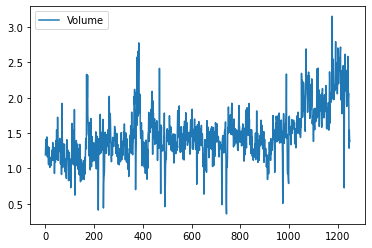

In [16]:
Smarket.plot(y='Volume');

# 4.7.2 Logistic Regression

In [17]:
# sm.GLM - generalized linear models
# sm.Logit - logistic regression model
# use family=sm.families.Binomial to run logistic regression

# predict Direction using lag1-lag5 and volume
allvars = Smarket.columns.drop(['Today', 'Direction', 'Year'])
design = MS(allvars)
X = design.fit_transform(Smarket)
y = Smarket.Direction == 'Up'  # up/down -> 1/0
glm = sm.GLM(y,
             X,
             family=sm.families.Binomial())  # log reg
results = glm.fit()
summarize(results)

,coef,std err,z,P>|z|
intercept,-0.1260,0.241,-0.523,0.601
Lag1,-0.0731,0.050,-1.457,0.145
Lag2,-0.0423,0.050,-0.845,0.398
Lag3,0.0111,0.050,0.222,0.824
Lag4,0.0094,0.050,0.187,0.851
Lag5,0.0103,0.050,0.208,0.835
Volume,0.1354,0.158,0.855,0.392


In [25]:
# predict() with no arguments computes preds for the training data
# preds are probabilities
probs = results.predict()
probs[:10]

array([0.50708413, 0.48146788, 0.48113883, 0.51522236, 0.51078116,
       0.50695646, 0.49265087, 0.50922916, 0.51761353, 0.48883778])

In [32]:
# apply threshold to convert probabilities to up/down
labels = np.array(["Down"]*len(probs))
labels

array(['Down', 'Down', 'Down', ..., 'Down', 'Down', 'Down'], dtype='<U4')

In [35]:
labels[probs>0.5] = "Up"

In [36]:
# confusion table
confusion_table(labels, Smarket.Direction)

Truth,Down,Up
Predicted,,
Down,145,141
Up,457,507


In [37]:
# fraction of overall correct preds
# training accuracy
(507+145)/1250, np.mean(labels == Smarket.Direction)

(0.5216, 0.5216)

In [40]:
# using holdout validation to get a better estimate of performance
train = (Smarket.Year < 2005)   # boolean array
Smarket_train = Smarket.loc[train]
Smarket_test = Smarket.loc[~train]
Smarket_test.shape

(252, 9)

In [41]:
# log reg on training subset
X_train , X_test = X.loc[train], X.loc[~train]
y_train , y_test = y.loc[train], y.loc[~train]
glm_train = sm.GLM(y_train ,
                   X_train ,
                   family=sm.families.Binomial())
results = glm_train.fit()
probs = results.predict(exog=X_test)

In [43]:
# getting training and testing labels
D = Smarket.Direction
L_train , L_test = D.loc[train], D.loc[~train]

In [44]:
# threshold to get predicted labels
labels = np.array(['Down']*252)
labels[probs >0.5] = 'Up'
confusion_table(labels , L_test)

Truth,Down,Up
Predicted,,
Down,77,97
Up,34,44


In [45]:
# test accuracy and test error
np.mean(labels == L_test), np.mean(labels != L_test)

(0.4801587301587302, 0.5198412698412699)

In [47]:
# using only predictors that have better p-values
model = MS(['Lag1', 'Lag2']).fit(Smarket)
X = model.transform(Smarket)
X_train , X_test = X.loc[train], X.loc[~train]
glm_train = sm.GLM(y_train ,
                   X_train ,
                   family=sm.families.Binomial())
results = glm_train.fit()
probs = results.predict(exog=X_test)
labels = np.array(['Down']*252)
labels[probs >0.5] = 'Up'
confusion_table(labels , L_test)

Truth,Down,Up
Predicted,,
Down,35,35
Up,76,106


In [48]:
(35+106) /252 ,106/(106+76)

(0.5595238095238095, 0.5824175824175825)

In [50]:
# predictions on custom data
newdata = pd.DataFrame({'Lag1':[1.2, 1.5],
                        'Lag2':[1.1, -0.8]});
newX = model.transform(newdata)
results.predict(newX)

0    0.479146
1    0.496094
dtype: float64

# 4.7.3 Linear Discriminant Analysis

In [51]:
lda = LDA(store_covariance=True)

In [53]:
# lda model automatically adds intercept
X_train , X_test = [M.drop(columns=['intercept'])
                    for M in [X_train , X_test]]
lda.fit(X_train , L_train)

LinearDiscriminantAnalysis(store_covariance=True)

In [54]:
# mean - average of each predictor within each class 
lda.means_

array([[ 0.04279022,  0.03389409],
       [-0.03954635, -0.03132544]])

In [55]:
lda.classes_

array(['Down', 'Up'], dtype='<U4')

In [58]:
lda.priors_

array([0.49198397, 0.50801603])

In [59]:
# linear discriminant vectors
lda.scalings_

array([[-0.64201904],
       [-0.51352928]])

In [66]:
lda_pred = lda.predict(X_test)

In [67]:
confusion_table(lda_pred, L_test)

Truth,Down,Up
Predicted,,
Down,35,35
Up,76,106


In [64]:
# prob of each class
lda_prob = lda.predict_proba(X_test)
np.all(
        np.where(lda_prob[:,1] >= 0.5, 'Up','Down') == lda_pred
        )

True

In [65]:
np.all(
        [lda.classes_[i] for i in np.argmax(lda_prob , 1)] ==
        lda_pred
        )

True

In [69]:
# Down, up columns
lda_prob

array([[0.49017925, 0.50982075],
       [0.4792185 , 0.5207815 ],
       [0.46681848, 0.53318152],
       [0.47400107, 0.52599893],
       [0.49278766, 0.50721234],
       [0.49385615, 0.50614385],
       [0.49510156, 0.50489844],
       [0.4872861 , 0.5127139 ],
       [0.49070135, 0.50929865],
       [0.48440262, 0.51559738],
       [0.49069628, 0.50930372],
       [0.51199885, 0.48800115],
       [0.48951523, 0.51048477],
       [0.47067612, 0.52932388],
       [0.47445929, 0.52554071],
       [0.47995834, 0.52004166],
       [0.49357753, 0.50642247],
       [0.50308938, 0.49691062],
       [0.49788061, 0.50211939],
       [0.48863309, 0.51136691],
       [0.50065681, 0.49934319],
       [0.51087353, 0.48912647],
       [0.50399248, 0.49600752],
       [0.49163351, 0.50836649],
       [0.50417721, 0.49582279],
       [0.50267505, 0.49732495],
       [0.49140429, 0.50859571],
       [0.48059641, 0.51940359],
       [0.48827181, 0.51172819],
       [0.50621869, 0.49378131],
       [0.

In [70]:
# there are no days with more than 90% prob of market decrease
np.sum(lda_prob[:,0] > 0.9)

0

# 4.7.4 Quadratic Discriminant Analysis

In [71]:
qda = QDA(store_covariance=True)
qda.fit(X_train , L_train)

QuadraticDiscriminantAnalysis(store_covariance=True)

In [72]:
qda.means_ , qda.priors_

(array([[ 0.04279022,  0.03389409],
        [-0.03954635, -0.03132544]]),
 array([0.49198397, 0.50801603]))

In [73]:
qda.covariance_[0]

array([[ 1.50662277, -0.03924806],
       [-0.03924806,  1.53559498]])

In [74]:
qda_pred = qda.predict(X_test)
confusion_table(qda_pred , L_test)

Truth,Down,Up
Predicted,,
Down,30,20
Up,81,121


In [75]:
# better than linear forms
np.mean(qda_pred == L_test)

0.5992063492063492

# 4.7.5 Naive Bayes

In [76]:
NB = GaussianNB()
NB.fit(X_train , L_train)

GaussianNB()

In [77]:
NB.classes_

array(['Down', 'Up'], dtype='<U4')

In [78]:
NB.class_prior_

array([0.49198397, 0.50801603])

In [79]:
# rows: classes, cols: features
NB.theta_

array([[ 0.04279022,  0.03389409],
       [-0.03954635, -0.03132544]])

In [80]:
NB.var_

array([[1.50355429, 1.53246749],
       [1.51401364, 1.48732877]])

In [81]:
X_train[L_train == 'Down'].mean()

Lag1    0.042790
Lag2    0.033894
dtype: float64

In [82]:
X_train[L_train == 'Down'].var(ddof=0)

Lag1    1.503554
Lag2    1.532467
dtype: float64

In [83]:
nb_labels = NB.predict(X_test)
confusion_table(nb_labels , L_test)

Truth,Down,Up
Predicted,,
Down,29,20
Up,82,121


Naive bayes performs better than LDA, but a bit worse than QDA

In [84]:
NB.predict_proba(X_test)[:5]

array([[0.4873288 , 0.5126712 ],
       [0.47623584, 0.52376416],
       [0.46529531, 0.53470469],
       [0.47484469, 0.52515531],
       [0.49020587, 0.50979413]])

# 4.7.6 K-Nearest Neighbors

In [85]:
# trying K=1
knn1 = KNeighborsClassifier(n_neighbors=1)
knn1.fit(X_train , L_train)
knn1_pred = knn1.predict(X_test)
confusion_table(knn1_pred , L_test)

Truth,Down,Up
Predicted,,
Down,43,58
Up,68,83


In [86]:
# performance low as K=1 has too much bias
(83+43)/252, np.mean(knn1_pred == L_test)

(0.5, 0.5)

In [87]:
knn3 = KNeighborsClassifier(n_neighbors=3)
knn3_pred = knn3.fit(X_train , L_train).predict(X_test)
np.mean(knn3_pred == L_test)

0.5317460317460317

### Applying KNN to the Caravan dataset

In [88]:
Caravan = load_data('Caravan')
Purchase = Caravan.Purchase
Purchase.value_counts()

No     5474
Yes     348
Name: Purchase, dtype: int64

The dataset is skewed, there are very few positive samples

In [89]:
# using all columns except Purchase
feature_df = Caravan.drop(columns=['Purchase'])

In [91]:
# variables with different scales affect the results of KNN
# if one variable has a much higher scale than the other, the other variable will have very less effect
# so standardize variables

scaler = StandardScaler(with_mean=True,   # subtract mean
                        with_std=True,    # divide by std
                        copy=True)        # copy data instead of changing in place

In [92]:
# fit and transform any data with this scaler
scaler.fit(feature_df)
X_std = scaler.transform(feature_df)

In [93]:
# check if all columns are scaled
feature_std = pd.DataFrame(
                X_std ,
                columns=feature_df.columns);
feature_std.std()

MOSTYPE     1.000086
MAANTHUI    1.000086
MGEMOMV     1.000086
MGEMLEEF    1.000086
MOSHOOFD    1.000086
              ...   
AZEILPL     1.000086
APLEZIER    1.000086
AFIETS      1.000086
AINBOED     1.000086
ABYSTAND    1.000086
Length: 85, dtype: float64

In [94]:
(X_train ,
 X_test ,
 y_train ,
 y_test) = train_test_split(feature_std ,
                            Purchase ,
                            test_size=1000,
                            random_state=0)

In [95]:
# fitting K=1
knn1 = KNeighborsClassifier(n_neighbors=1)
knn1_pred = knn1.fit(X_train , y_train).predict(X_test)
np.mean(y_test != knn1_pred), np.mean(y_test != "No")

(0.111, 0.067)

In [96]:
confusion_table(knn1_pred , y_test)

Truth,No,Yes
Predicted,,
No,880,58
Yes,53,9


### Tuning Parameters

In [97]:
# use a for loop on different values of K
for K in range(1,6):
    knn = KNeighborsClassifier(n_neighbors=K)
    knn_pred = knn.fit(X_train , y_train).predict(X_test)
    C = confusion_table(knn_pred, y_test)
    templ = ('K={0:d}: # predicted to rent: {1:>2},' +
             ' # who did rent {2:d}, accuracy {3:.1%}')
    pred = C.loc['Yes'].sum()
    did_rent = C.loc['Yes','Yes']
    print(templ.format(
          K,
          pred ,
          did_rent ,
          did_rent / pred))

K=1: # predicted to rent: 62, # who did rent 9, accuracy 14.5%
K=2: # predicted to rent:  6, # who did rent 1, accuracy 16.7%
K=3: # predicted to rent: 20, # who did rent 3, accuracy 15.0%
K=4: # predicted to rent:  4, # who did rent 0, accuracy 0.0%
K=5: # predicted to rent:  7, # who did rent 1, accuracy 14.3%


### Comparison to Logistic Regression

In [98]:
# using sklearn logistic regressor
# using a large c converges to logistic regression rather than ridge regression
logit = LogisticRegression(C=1e10 , solver='liblinear')
logit.fit(X_train , y_train)
logit_pred = logit.predict_proba(X_test)
logit_labels = np.where(logit_pred[:,1] > 5, 'Yes', 'No')
confusion_table(logit_labels , y_test)

Truth,No,Yes
Predicted,,
No,933,67
Yes,0,0


In [99]:
# using 0.25 threshold instead
logit_labels = np.where(logit_pred[:,1]>0.25, 'Yes', 'No')
confusion_table(logit_labels , y_test)

Truth,No,Yes
Predicted,,
No,913,58
Yes,20,9


This has a much better result

# 4.7.7 Linear and Poisson Regression on the Bikeshare data

In [100]:
Bike = load_data("Bikeshare")

In [101]:
Bike.shape, Bike.columns

((8645, 15),
 Index(['season', 'mnth', 'day', 'hr', 'holiday', 'weekday', 'workingday',
        'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'casual',
        'registered', 'bikers'],
       dtype='object'))

### Linear Regression

In [113]:
X = MS(['mnth',
        'hr',
        'workingday',
        'temp',
        'weathersit']).fit_transform(Bike)
Y = Bike['bikers']
M_lm = sm.OLS(Y, X).fit()
summarize(M_lm)

,coef,std err,t,P>|t|
intercept,-68.6317,5.307,-12.932,0.000
mnth[Feb],6.8452,4.287,1.597,0.110
mnth[March],16.5514,4.301,3.848,0.000
mnth[April],41.4249,4.972,8.331,0.000
mnth[May],72.5571,5.641,12.862,0.000
mnth[June],67.8187,6.544,10.364,0.000
mnth[July],45.3245,7.081,6.401,0.000
mnth[Aug],53.2430,6.640,8.019,0.000
mnth[Sept],66.6783,5.925,11.254,0.000
mnth[Oct],75.8343,4.950,15.319,0.000


In [114]:
# using a different encoding of hr and mnth
hr_encode = contrast('hr', 'sum')
mnth_encode = contrast('mnth', 'sum')

In [115]:
X2 = MS([mnth_encode,
        hr_encode,
        'workingday',
        'temp',
        'weathersit']).fit_transform(Bike)
M2_lm = sm.OLS(Y, X2).fit()
S2 = summarize(M2_lm)
S2

,coef,std err,t,P>|t|
intercept,73.5974,5.132,14.340,0.000
mnth[Jan],-46.0871,4.085,-11.281,0.000
mnth[Feb],-39.2419,3.539,-11.088,0.000
mnth[March],-29.5357,3.155,-9.361,0.000
mnth[April],-4.6622,2.741,-1.701,0.089
mnth[May],26.4700,2.851,9.285,0.000
mnth[June],21.7317,3.465,6.272,0.000
mnth[July],-0.7626,3.908,-0.195,0.845
mnth[Aug],7.1560,3.535,2.024,0.043
mnth[Sept],20.5912,3.046,6.761,0.000


In M2_lm, a coefficient estimate is reported for all but level 23 of hr and 
level Dec of mnth. The (unreported) coefficient estimate for the last level of mnth is not zero: instead, it equals the negative of the sum of the coefficient estimates for all of the other levels. This means that the coefficients of hr and mnth in M2_lm will always sum to zero, and can be interpreted as the difference from the mean level.

In [116]:
# the choice of coding doesn't matter, onky interpretation changes
np.allclose(M_lm.fittedvalues , M2_lm.fittedvalues)

True

In [117]:
coef_month = S2[S2.index.str.contains('mnth')]['coef']
coef_month

mnth[Jan]     -46.0871
mnth[Feb]     -39.2419
mnth[March]   -29.5357
mnth[April]    -4.6622
mnth[May]      26.4700
mnth[June]     21.7317
mnth[July]     -0.7626
mnth[Aug]       7.1560
mnth[Sept]     20.5912
mnth[Oct]      29.7472
mnth[Nov]      14.2229
Name: coef, dtype: float64

In [118]:
# addind mnth[Dec] coefficient
months = Bike['mnth'].dtype.categories
coef_month = pd.concat([
                        coef_month ,
                        pd.Series([-coef_month.sum()],
                                   index=['mnth[Dec]'
                                  ])
                        ])
coef_month

mnth[Jan]     -46.0871
mnth[Feb]     -39.2419
mnth[March]   -29.5357
mnth[April]    -4.6622
mnth[May]      26.4700
mnth[June]     21.7317
mnth[July]     -0.7626
mnth[Aug]       7.1560
mnth[Sept]     20.5912
mnth[Oct]      29.7472
mnth[Nov]      14.2229
mnth[Dec]       0.3705
dtype: float64

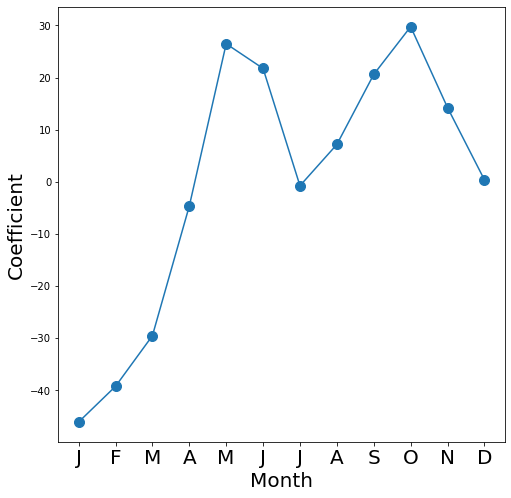

In [119]:
# plotting coefficients
fig_month , ax_month = subplots(figsize=(8,8))
x_month = np.arange(coef_month.shape[0])
ax_month.plot(x_month , coef_month , marker='o', ms=10)
ax_month.set_xticks(x_month)
ax_month.set_xticklabels([l[5] for l in coef_month.index], fontsize
    =20)
ax_month.set_xlabel('Month', fontsize=20)
ax_month.set_ylabel('Coefficient', fontsize=20);

In [120]:
coef_hr = S2[S2.index.str.contains('hr')]['coef']
coef_hr = coef_hr.reindex(['hr[{0}]'.format(h) for h in range(23)])
coef_hr = pd.concat([coef_hr ,
                    pd.Series([-coef_hr.sum()], index=['hr[23]'])
                    ])

In [122]:
coef_hr

hr[0]     -96.1420
hr[1]    -110.7213
hr[2]    -117.7212
hr[3]    -127.2828
hr[4]    -133.0495
hr[5]    -120.2775
hr[6]     -75.5424
hr[7]      23.9511
hr[8]     127.5199
hr[9]      24.4399
hr[10]    -12.3407
hr[11]      9.2814
hr[12]     41.1417
hr[13]     39.8939
hr[14]     30.4940
hr[15]     35.9445
hr[16]     82.3786
hr[17]    200.1249
hr[18]    173.2989
hr[19]     90.1138
hr[20]     29.4071
hr[21]     -8.5883
hr[22]    -37.0194
hr[23]    -69.3046
dtype: float64

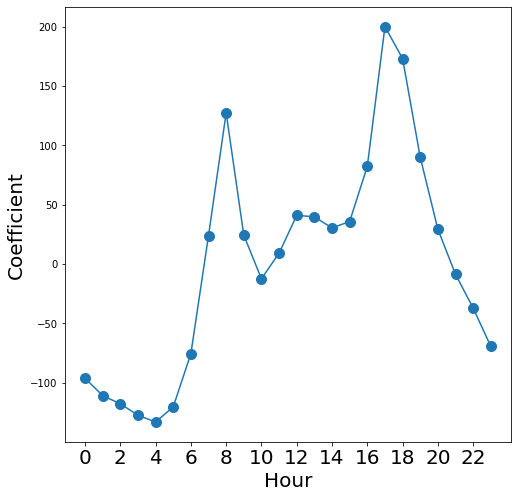

In [123]:
# plotting hr coefficients
fig_hr , ax_hr = subplots(figsize=(8,8))
x_hr = np.arange(coef_hr.shape[0])
ax_hr.plot(x_hr , coef_hr , marker='o', ms=10)
ax_hr.set_xticks(x_hr[::2])
ax_hr.set_xticklabels(range(24)[::2], fontsize =20)
ax_hr.set_xlabel('Hour', fontsize=20)
ax_hr.set_ylabel('Coefficient', fontsize=20);

### Poisson Regression

In [124]:
# specifying poisson family
M_pois = sm.GLM(Y, X2, family=sm.families.Poisson()).fit()

In [125]:
# getting coefficients
S_pois = summarize(M_pois)
coef_month = S_pois[S_pois.index.str.contains('mnth')]['coef']
coef_month = pd.concat([coef_month ,
                        pd.Series([-coef_month.sum()],
                                    index=['mnth[Dec]'])])
coef_hr = S_pois[S_pois.index.str.contains('hr')]['coef']
coef_hr = pd.concat([coef_hr ,
                    pd.Series([-coef_hr.sum()],
                    index=['hr[23]'])])

C:\Users\Amruthaa\AppData\Local\Temp\ipykernel_12104\3649167194.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_hr.set_xticklabels(range(24)[::2], fontsize =20)


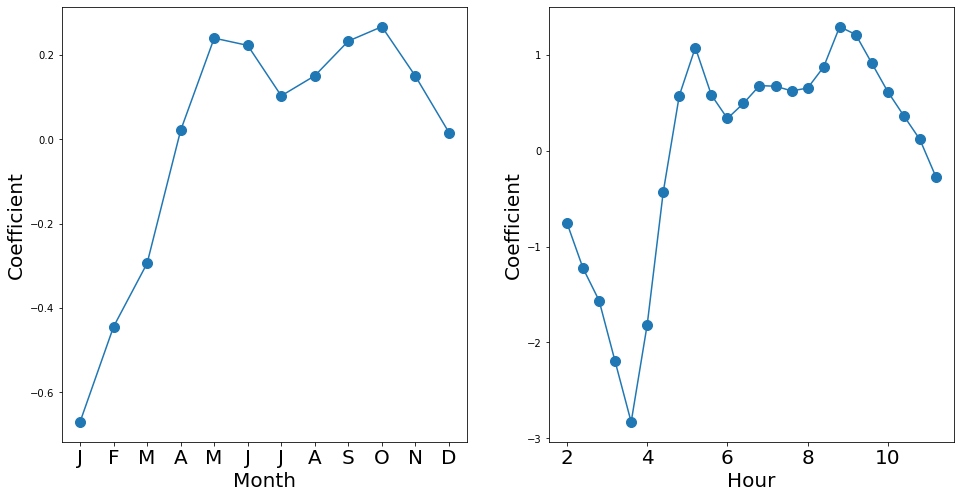

In [126]:
fig_pois , (ax_month , ax_hr) = subplots(1, 2, figsize=(16,8))
ax_month.plot(x_month , coef_month , marker='o', ms=10)
ax_month.set_xticks(x_month)
ax_month.set_xticklabels([l[5] for l in coef_month.index], fontsize
    =20)
ax_month.set_xlabel('Month', fontsize=20)
ax_month.set_ylabel('Coefficient', fontsize=20)
ax_hr.plot(x_hr , coef_hr , marker='o', ms=10)
ax_hr.set_xticklabels(range(24)[::2], fontsize =20)
ax_hr.set_xlabel('Hour', fontsize=20)
ax_hr.set_ylabel('Coefficient', fontsize=20);

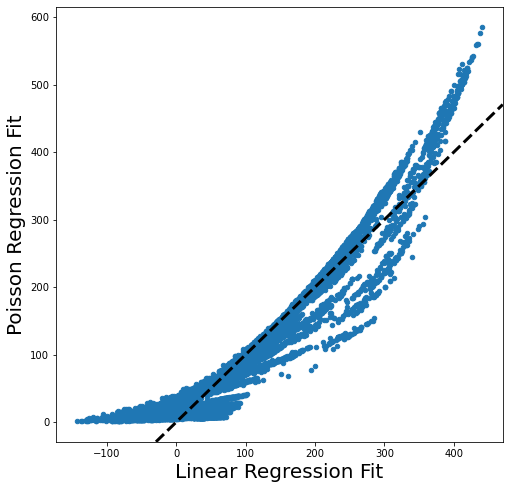

In [127]:
# comparing fitted values of both models
fig , ax = subplots(figsize=(8, 8))
ax.scatter(M2_lm.fittedvalues ,
            M_pois.fittedvalues ,
            s=20)
ax.set_xlabel('Linear Regression Fit', fontsize=20)
ax.set_ylabel('Poisson Regression Fit', fontsize=20)
ax.axline([0,0], c='black', linewidth=3,
            linestyle='--', slope=1);

The predictions from the Poisson regression model are correlated with
those from the linear model; however, the former are non-negative. As a
result the Poisson regression predictions tend to be larger than those from
the linear model for either very low or very high levels of ridership.